<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
    - H-L Test for Accuracy by segments (Not done in this notebook)
###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

C:\Users\admin\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\admin\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\admin\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\admin\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "

In [ ]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [ ]:
bankloans.columns

In [ ]:
bankloans.info()

In [ ]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

In [ ]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

In [ ]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

In [ ]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [ ]:
num_summary

In [ ]:
#Detailed profiling using pandas profiling

pandas_profiling.ProfileReport(bankloans)

In [ ]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull()==0]
bankloans_new = bankloans_num[bankloans_num.default.isnull()==1]

In [ ]:
pandas_profiling.ProfileReport(bankloans_existing)

In [ ]:

#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [ ]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [ ]:
bankloans_existing.corr()

In [ ]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_existing.corr())

In [ ]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = bankloans_existing)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

bp = PdfPages('BoxPlots with Total View.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(y=num_variable, data = bankloans_existing)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

###### 2.1 Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest/ANOVA) and Categorical(Chisquare)

In [ ]:
## Numerical Variable
tstats_df = pd.DataFrame()
for num_variable in numeric_var_names:
    tstats = stats.ttest_ind(bankloans_existing[bankloans_existing['default']==1][num_variable],bankloans_existing[bankloans_existing['default']==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

print(tstats_df)

###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

In [ ]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

In [ ]:
print('These variables need bucketing - creddebt, othdebt, debtinc, employ, income ')
bankloans_existing.columns

In [ ]:
bankloans_existing[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

In [ ]:
#bucekting
#bankloans_existing['creddebt_extreme'] = bankloans_existing['creddebt'].apply(lambda x: 0 if 162 < x < 221 else 1)
#bankloans_existing['othdebt_extreme'] = bankloans_existing['othdebt'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'] = bankloans_existing['debtinc'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'].value_counts()

###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [ ]:

somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

In [ ]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

In [ ]:
features

In [ ]:
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+ed+employ+othdebt', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

In [ ]:
#Train and Test split

train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

In [ ]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()

In [ ]:
dir(result)

In [ ]:
logreg = sm.logit(formula='default ~ address+debtinc+employ+othdebt' , data=train_X)
result = logreg.fit()

In [ ]:
 result.summary2()

In [ ]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

In [ ]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

In [ ]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

In [ ]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [ ]:
roc_like_df

In [ ]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [ ]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [ ]:
roc_like_df

In [ ]:
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

In [ ]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()
# (117+236)/(117+236+120+17)

In [ ]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

In [ ]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

In [ ]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)

In [ ]:
df

In [ ]:
train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)

In [ ]:
new_cust_prob = pd.DataFrame(result.predict(bankloans_new))


new_cust_prob.columns = ['prob1']

bankloans_new1=pd.concat([bankloans_new, new_cust_prob.prob1], axis=1)

In [ ]:
new_cust_prob.head(5)

In [ ]:
bankloans_new1.head()

In [ ]:
bankloans_new1['predicted'] = bankloans_new1['prob1'].apply(lambda x: 1 if x > 0.29 else 0)

In [ ]:
bankloans_new1.head()

# Decision Trees

In [1]:
# Decision Trees
import sklearn.tree as dt
import sklearn.ensemble as en

In [2]:
dir(dt)

['DecisionTreeClassifier',
 'DecisionTreeRegressor',
 'ExtraTreeClassifier',
 'ExtraTreeRegressor',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_criterion',
 '_splitter',
 '_tree',
 '_utils',
 'export',
 'export_graphviz',
 'tree']

In [10]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.grid_search import GridSearchCV
import pandas as pd

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
bankloans = pd.read_csv( 'bankloans.csv' )

In [14]:
bankloans_existing = bankloans[bankloans.default.isnull()==0]
bankloans_new = bankloans[bankloans.default.isnull()==1]

In [15]:
X = bankloans_existing 

In [16]:
X.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [17]:
features = X.columns.difference(['default'])
features

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [18]:
from sklearn.cross_validation import train_test_split


train_X, test_X, train_y, test_y = train_test_split( X[features],
                                                  X['default'],
                                                  test_size = 0.3,
                                                  random_state = 142 )

In [11]:
DecisionTreeClassifier?

In [19]:
clf_tree = DecisionTreeClassifier( max_depth = 3 )
clf_tree.fit( train_X, train_y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
dir(clf_tree)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_get_param_names',
 '_validate_X_predict',
 'apply',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_classes_',
 'n_features_',
 'n_outputs_',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'presort',

In [21]:
clf_tree.predict_proba(train_X)

array([[ 0.89655172,  0.10344828],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.67816092,  0.32183908],
       [ 0.32352941,  0.67647059],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.67816092,  0.32183908],
       [ 0.67816092,  0.32183908],
       [ 0.09090909,  0.90909091],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.89655172,  0.10344828],
       [ 0.515625  ,  0.484375  ],
       [ 0.92887029,  0.07112971],
       [ 0.32352941,  0.67647059],
       [ 0.515625  ,  0.484375  ],
       [ 0.15384615,  0.84615385],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.67816092,  0.32183908],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.92887029,  0.07112971],
       [ 0.515625  ,  0.484375  ],
       [ 0.92887029,

In [22]:
pd.DataFrame(clf_tree.predict_proba(train_X))

,0,1
0,0.896552,0.103448
1,0.928870,0.071130
2,0.928870,0.071130
3,0.928870,0.071130
4,0.678161,0.321839
5,0.323529,0.676471
6,0.928870,0.071130
7,0.928870,0.071130
8,0.928870,0.071130
9,0.928870,0.071130


In [41]:
train_y.head(100)

673    1.0
342    0.0
182    0.0
668    0.0
611    0.0
312    1.0
174    0.0
496    0.0
489    0.0
301    0.0
240    0.0
307    0.0
89     1.0
160    0.0
441    0.0
73     0.0
147    0.0
83     0.0
461    1.0
91     1.0
6      0.0
177    0.0
198    0.0
243    0.0
208    0.0
138    0.0
566    0.0
321    1.0
295    0.0
1      0.0
      ... 
256    0.0
119    1.0
275    1.0
539    1.0
401    0.0
315    0.0
607    0.0
634    0.0
520    0.0
359    0.0
662    0.0
371    0.0
440    0.0
238    0.0
218    1.0
54     0.0
509    0.0
64     0.0
69     1.0
606    1.0
609    0.0
266    0.0
640    0.0
694    0.0
604    1.0
647    0.0
449    1.0
135    0.0
385    0.0
184    0.0
Name: default, Length: 100, dtype: float64

In [46]:
pd.DataFrame(clf_tree.predict_proba( train_X ))

,0,1
0,0.896552,0.103448
1,0.928870,0.071130
2,0.928870,0.071130
3,0.928870,0.071130
4,0.678161,0.321839
5,0.323529,0.676471
6,0.928870,0.071130
7,0.928870,0.071130
8,0.928870,0.071130
9,0.928870,0.071130


In [50]:
pd.concat?

In [53]:
range(0,490)

range(0, 490)

In [54]:
train_y.index = pd.DataFrame(clf_tree.predict_proba( train_X )).index

In [55]:
train_y.index

RangeIndex(start=0, stop=490, step=1)

In [73]:
tree_train_pred_prob = pd.concat([ pd.DataFrame(clf_tree.predict_proba( train_X )), train_y,], axis=1, ignore_index=True)

In [74]:
tree_train_pred_prob.columns = ['pred_prob_0', 'pred_prob_1', 'actual']

In [75]:
tree_train_pred_prob.head(10)

,pred_prob_0,pred_prob_1,actual
0,0.896552,0.103448,1.0
1,0.928870,0.071130,0.0
2,0.928870,0.071130,0.0
3,0.928870,0.071130,0.0
4,0.678161,0.321839,0.0
5,0.323529,0.676471,1.0
6,0.928870,0.071130,0.0
7,0.928870,0.071130,0.0
8,0.928870,0.071130,0.0
9,0.928870,0.071130,0.0


In [76]:
dir(metrics)

['SCORERS',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'auc',
 'average_precision_score',
 'base',
 'brier_score_loss',
 'calinski_harabaz_score',
 'classification',
 'classification_report',
 'cluster',
 'cohen_kappa_score',
 'completeness_score',
 'confusion_matrix',
 'consensus_score',
 'coverage_error',
 'euclidean_distances',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'get_scorer',
 'hamming_loss',
 'hinge_loss',
 'homogeneity_completeness_v_measure',
 'homogeneity_score',
 'jaccard_similarity_score',
 'label_ranking_average_precision_score',
 'label_ranking_loss',
 'log_loss',
 'make_scorer',
 'matthews_corrcoef',
 'mean_absolute_error',
 'mean_squared_error',
 'mean_squared_log_error',
 'median_absolute_error',
 'mutual_info_score',
 'normalized_mutual_info_score',
 'pa

In [77]:
tree_train_pred_prob["actual"]

0      1.0
1      0.0
2      0.0
3      0.0
4      0.0
5      1.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     1.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     1.0
19     1.0
20     0.0
21     0.0
22     0.0
23     0.0
24     0.0
25     0.0
26     0.0
27     1.0
28     0.0
29     0.0
      ... 
460    0.0
461    1.0
462    0.0
463    0.0
464    0.0
465    1.0
466    0.0
467    0.0
468    0.0
469    1.0
470    0.0
471    0.0
472    1.0
473    1.0
474    1.0
475    0.0
476    0.0
477    1.0
478    0.0
479    0.0
480    1.0
481    0.0
482    0.0
483    0.0
484    0.0
485    0.0
486    0.0
487    0.0
488    0.0
489    0.0
Name: actual, Length: 490, dtype: float64

In [78]:
bankloans.head(50)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
5,41,2,5,5,25,10.2,0.392700,2.157300,0.0
6,39,1,20,9,67,30.6,3.833874,16.668126,0.0
7,43,1,12,11,38,3.6,0.128592,1.239408,0.0
8,24,1,3,4,19,24.4,1.358348,3.277652,1.0
9,36,1,0,13,25,19.7,2.777700,2.147300,0.0


In [79]:
metrics.roc_auc_score?

In [80]:
tree_train_pred_prob["actual"].head(10)

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
5    1.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: actual, dtype: float64

In [81]:
tree_train_pred_prob["actual"].astype('object')

0      1
1      0
2      0
3      0
4      0
5      1
6      0
7      0
8      0
9      0
10     0
11     0
12     1
13     0
14     0
15     0
16     0
17     0
18     1
19     1
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     1
28     0
29     0
      ..
460    0
461    1
462    0
463    0
464    0
465    1
466    0
467    0
468    0
469    1
470    0
471    0
472    1
473    1
474    1
475    0
476    0
477    1
478    0
479    0
480    1
481    0
482    0
483    0
484    0
485    0
486    0
487    0
488    0
489    0
Name: actual, Length: 490, dtype: object

In [82]:
y_true = np.array(tree_train_pred_prob["actual"])
y_scores = np.array(tree_train_pred_prob["pred_prob_1"])

In [83]:
metrics.roc_auc_score(y_true, y_scores)

0.83461658841940545

In [ ]:
#if the data is balanced date, the below steps make sense

In [84]:
tree_train_pred = pd.DataFrame( { 'actual':  train_y,
                            'pred': clf_tree.predict( train_X )} )



In [85]:
tree_train_pred.head(10)

,actual,pred
0,1.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,1.0,1.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [86]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'pred': clf_tree.predict( test_X ) } )

In [ ]:
tree_test_pred.head(10)

In [87]:
metrics.accuracy_score( tree_train_pred.actual, tree_train_pred.pred)

0.80816326530612248

In [88]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.pred )

0.76666666666666672

Text(0.5,46.5,'Predicted label')

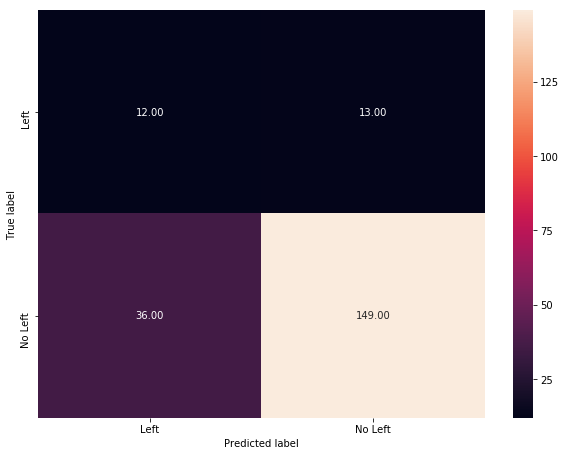

In [90]:
tree_cm = metrics.confusion_matrix( tree_test_pred.pred,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True, fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [91]:
DecisionTreeClassifier?

In [94]:
#Fine Tuning the parameters
param_grid = {'max_depth': np.arange(3, 8), 'max_features': np.arange(3,5)}

In [95]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree.fit( train_X, train_y )

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7]), 'max_features': array([3, 4])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [96]:
tree.best_params_

{'max_depth': 3, 'max_features': 3}

In [97]:
tree.best_score_

0.763265306122449

In [ ]:
#Building Final Decision Tree Model
train_X.head()

In [109]:
clf_tree = DecisionTreeClassifier( max_depth = 3, max_features=3 )
clf_tree.fit( train_X, train_y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [110]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': clf_tree.predict( test_X ) } )

In [111]:
tree_test_pred.sample( n = 10 )

,actual,predicted
386,0.0,0.0
88,0.0,0.0
525,0.0,0.0
166,1.0,1.0
395,0.0,1.0
374,0.0,0.0
357,1.0,1.0
658,0.0,1.0
180,0.0,0.0
163,0.0,0.0


In [112]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.73333333333333328

Text(0.5,46.5,'Predicted label')

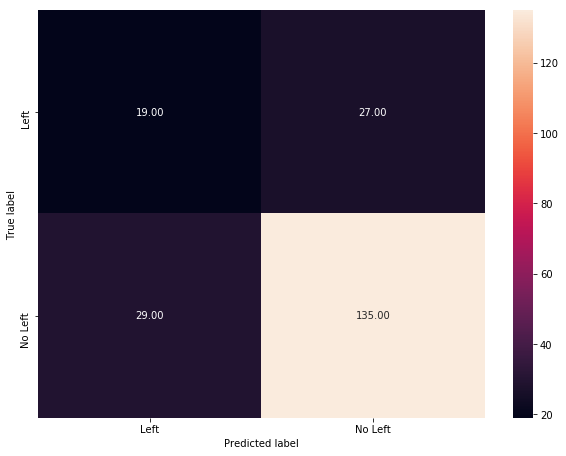

In [113]:
tree_cm = metrics.confusion_matrix( tree_test_pred.predicted,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [114]:
#Generate Rules from Decision Trees
#To create a decision tree visualization graph.
#Install GraphViz (As per the OS and version you are using)
#pip install pydotplus
#Add the path to environmental variables
#Note: The notebook needs a restart.

In [115]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [116]:
export_graphviz( clf_tree,
              out_file = "hr_tree.odt",
              feature_names = train_X.columns )

In [117]:
import pydotplus as pdot

chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'hr_tree.odt' )

In [118]:
chd_tree_graph.write_jpg( 'hr_tree.jpg' )

True

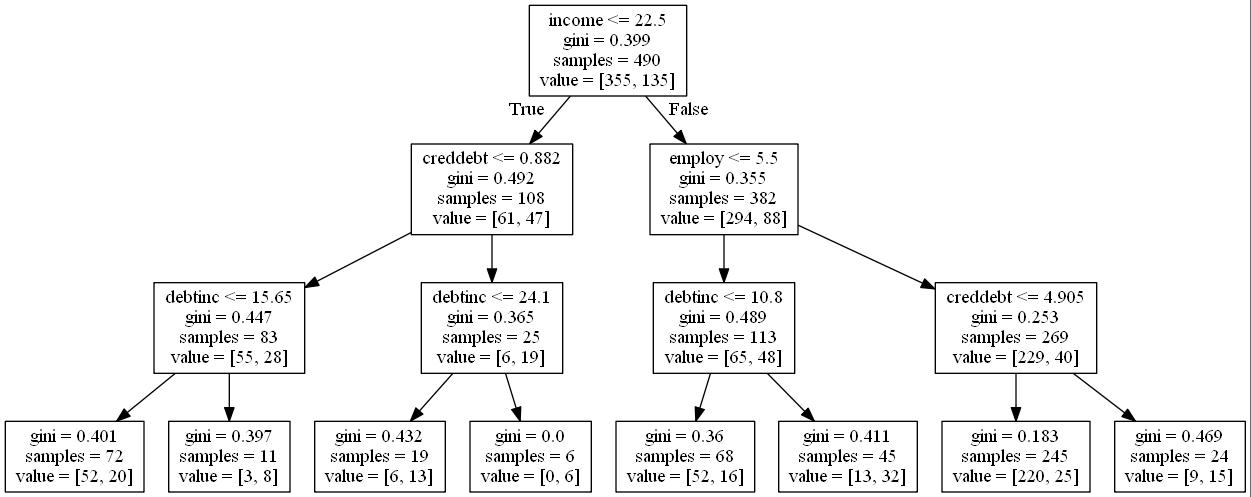

In [119]:
from IPython.display import Image
Image(filename='hr_tree.jpg')